# Geocorrection & Mosaicing

This notebook applies pre-computed geometric corrections present in the GSQ hyperspectral data sets to generate georeferenced hyperspectral ENVI data cubes for each flight swath. Swaths are then combined into a single data cube mosaic.

In [1]:
# import standard libaries
import os, warnings, subprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# import gis libraries
import rasterio
from osgeo import gdal

# filter warnings for tidy output
warnings.filterwarnings("ignore")

## 1. Find Files

Find the processed reflectance swath data and their corresponding geometry lookup tables.

In [2]:
# set paths to unzipped data directory for survey block D
data_dir = r'/storage/gsq_hymap/raw/block-d'

# get paths to geometry lookup table & reflectance BIL grids
glt_fns, ref_fns = [], []
for path, subdirs, files in os.walk(data_dir):
  for name in files:
    if 'ref.bil' in name:
      ref_fns.append(os.path.join(path, name))
    if 'glt.bsq' in name:
      glt_fns.append(os.path.join(path, name))

sorted(ref_fns), sorted(glt_fns)

(['/storage/gsq_hymap/raw/block-d/nrm_28/reflectance/nrm_28_ref.bil',
  '/storage/gsq_hymap/raw/block-d/nrm_29/reflectance/nrm_29_ref.bil',
  '/storage/gsq_hymap/raw/block-d/nrm_30/reflectance/nrm_30_ref.bil',
  '/storage/gsq_hymap/raw/block-d/nrm_31/reflectance/nrm_31_ref.bil',
  '/storage/gsq_hymap/raw/block-d/nrm_32/reflectance/nrm_32_ref.bil',
  '/storage/gsq_hymap/raw/block-d/nrm_33/reflectance/nrm_33_ref.bil',
  '/storage/gsq_hymap/raw/block-d/nrm_34/reflectance/nrm_34_ref.bil',
  '/storage/gsq_hymap/raw/block-d/nrm_35/reflectance/nrm_35_ref.bil',
  '/storage/gsq_hymap/raw/block-d/nrm_36/reflectance/nrm_36_ref.bil',
  '/storage/gsq_hymap/raw/block-d/nrm_37/reflectance/nrm_37_ref.bil'],
 ['/storage/gsq_hymap/raw/block-d/nrm_28/geocorrection/nrm_28_glt.bsq',
  '/storage/gsq_hymap/raw/block-d/nrm_29/geocorrection/nrm_29_glt.bsq',
  '/storage/gsq_hymap/raw/block-d/nrm_30/geocorrection/nrm_30_glt.bsq',
  '/storage/gsq_hymap/raw/block-d/nrm_31/geocorrection/nrm_31_glt.bsq',
  '/storage

## 2. Apply Geometric Corrections to Swaths

Use the geometry lookup table rasters and reflectance data cubes to generate georeferenced ENVI grids containing the reflectance data for each flight swath. I used information about lookup tables from the [L3HarrisGeospatial website](https://www.l3harrisgeospatial.com/docs/georeferencefrominputgeometry.html#Georefer2) to figure out how they relate to the reflactance BIL files. This is fairly memory intensive given the need to load the entire swath into memory, I recommend a machine with 32GB of memory available.

In [3]:
# set an output path
interim_dir = r'/storage/gsq_hymap/interim'

# loop through the files, apply the geometry lookup table to create a georeferenced hypersepctral ENVI grid
for ref_fn, glt_fn in zip(sorted(ref_fns), sorted(glt_fns)):
  with rasterio.open(ref_fn,'r') as ref_src, rasterio.open(glt_fn,'r') as glt_src:
    # create output shape tuple, create metadata dictionary for output
    out_shape = (ref_src.count, glt_src.height, glt_src.width)
    meta = glt_src.meta.copy()
    meta.update({'count':out_shape[0], 'drive':'ENVI', 'nodata':-999, 'dtype':ref_src.dtypes[0]})
    # create output file name and read hyperspectral band names into nanometres
    out_fn = os.path.join(interim_dir, os.path.basename(ref_fn).replace('ref.bil','geocor_ref.dat'))
    bands = ['{}nm'.format(round(float(x.split()[-1].strip('()'))*1000,2)) for x in ref_src.descriptions]
    # read the geometry lookup table containing spatial coordinates for raw hyperspectral pixel indices
    gxy = glt_src.read() 
    # read the hyperspectral data cube into memory, create an output array
    hysp_dat = ref_src.read()
    out_dat = np.ones(out_shape, dtype=hysp_dat.dtype) * -999
    # get masks for geometry lookup pixels with non-zero pixel indices (negatives are nearest neighbour infil)
    pos_idx = gxy[0] > 0
    neg_idx = gxy[0] < 0
    # insert hyperspectral data into the output array for the positive indices, subtract 1 for pythonic indexing
    out_dat[:, pos_idx] = hysp_dat[:, gxy[1,pos_idx].flatten() - 1, gxy[0,pos_idx].flatten() - 1]
    # insert hyperspectral data into output for the negative indices, subtract 1 again for pythonic indexing
    out_dat[:, neg_idx] = hysp_dat[:, abs(gxy[1,neg_idx].flatten()) - 1, abs(gxy[0,neg_idx].flatten()) - 1]
    # save the output data
    with rasterio.open(out_fn,'w',**meta) as dst:
      for i in tqdm(range(out_shape[0])):
        dst.write(out_dat[i],i+1)
        dst.set_band_description(i+1, bands[i])
      dst.close()
    glt_src.close()
    ref_src.close()
    # print progress
    print(f'Saved ENVI grid: {out_fn}')

100%|██████████| 126/126 [00:08<00:00, 15.66it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_28_geocor_ref.dat


100%|██████████| 126/126 [00:17<00:00,  7.35it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_29_geocor_ref.dat


100%|██████████| 126/126 [00:08<00:00, 15.01it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_30_geocor_ref.dat


100%|██████████| 126/126 [00:10<00:00, 11.88it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_31_geocor_ref.dat


100%|██████████| 126/126 [00:11<00:00, 11.24it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_32_geocor_ref.dat


100%|██████████| 126/126 [00:13<00:00,  9.11it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_33_geocor_ref.dat


100%|██████████| 126/126 [00:13<00:00,  9.11it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_34_geocor_ref.dat


100%|██████████| 126/126 [00:15<00:00,  7.96it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_35_geocor_ref.dat


100%|██████████| 126/126 [00:18<00:00,  6.89it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_36_geocor_ref.dat


100%|██████████| 126/126 [00:20<00:00,  6.29it/s]


Saved ENVI grid: /storage/gsq_hymap/interim/nrm_37_geocor_ref.dat


## 3. Generate Mosaic With GDAL

Use GDAL to mosaic the now georeferenced swath data cubes into a new data cube. This is a pretty slow procedure leveraging GDAL's virtual raster and translate modules. Another key point to note here is that we are not applying a levelling workflow so we will likely get a mosaic with significant acquisition swath artefacts. Advice on a faster and/or more appropriate method for mosaicing would be greatly appreciated here.

In [2]:
# generate a list of output files to mosaic
interim_dir = r'/storage/gsq_hymap/interim'
swath_fns = sorted([os.path.join(interim_dir,x) for x in os.listdir(interim_dir) if x.endswith('ref.dat')])
swath_fns

['/storage/gsq_hymap/interim/nrm_28_geocor_ref.dat',
 '/storage/gsq_hymap/interim/nrm_29_geocor_ref.dat',
 '/storage/gsq_hymap/interim/nrm_30_geocor_ref.dat',
 '/storage/gsq_hymap/interim/nrm_31_geocor_ref.dat',
 '/storage/gsq_hymap/interim/nrm_32_geocor_ref.dat',
 '/storage/gsq_hymap/interim/nrm_33_geocor_ref.dat',
 '/storage/gsq_hymap/interim/nrm_34_geocor_ref.dat',
 '/storage/gsq_hymap/interim/nrm_35_geocor_ref.dat',
 '/storage/gsq_hymap/interim/nrm_36_geocor_ref.dat',
 '/storage/gsq_hymap/interim/nrm_37_geocor_ref.dat']

In [3]:
# set output file paths
out_dir = r'/storage/gsq_hymap/processed'
out_vrt = os.path.join(out_dir, 'GSQ_block-d_mosaic_ref.vrt') 
out_envi = os.path.join(out_dir, 'GSQ_block-d_mosaic_ref.dat') 

# create a virtual raster, use nearest neighbour resampling for speed
vrt_options = gdal.BuildVRTOptions(resampleAlg='near', addAlpha=False)
vrt = gdal.BuildVRT(out_vrt, swath_fns, options=vrt_options)
vrt = None
print('Virtual raster created')

# create a mosaic ENVI grid from the virtual raster
src_vrt = gdal.Open(out_vrt)
out_dst = gdal.Translate(out_envi, src_vrt, options=['-of','ENVI'])
out_dst = None
print('ENVI raster created')

# add band names to the ENVI output file
bands = [x for x in rasterio.open(swath_fns[0],'r').descriptions]
with rasterio.open(out_envi, 'r+') as dst:
  for i in range(len(bands)):
    dst.set_band_description(i+1, bands[i])
  dst.close()

# remove virtual raster
os.remove(out_vrt)

Virtual raster created
ENVI raster created


## 4. Plot ~2200nm Response

This is quite stripey and may benefit from some levelling procedure.

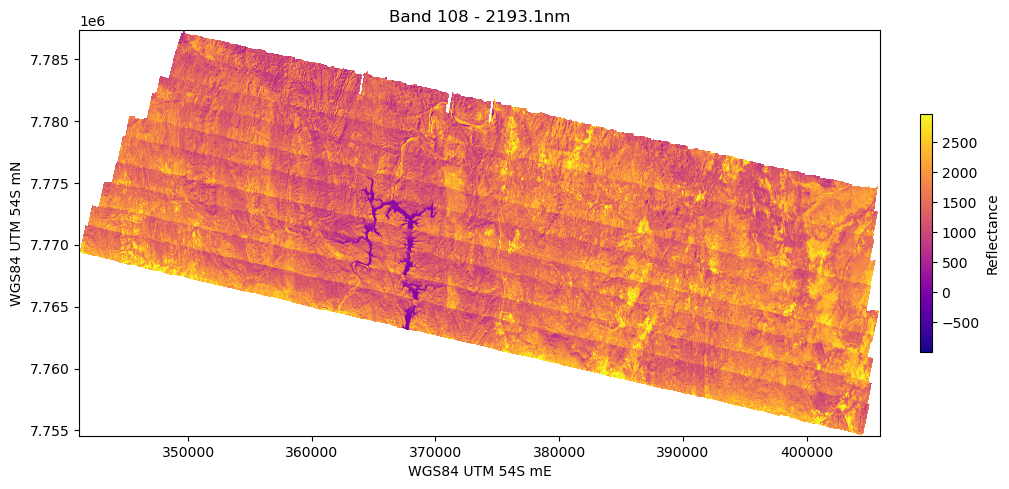

In [37]:
# read 2200nm band from the mosaic, read dimensions of the mosaic
with rasterio.open(out_envi,'r') as src:
  wvl = np.array([float(x.strip('nm')) for x in src.descriptions])
  idx = np.argmin(abs(wvl-2200))
  band = src.read(int(idx) + 1)
  band = np.ma.masked_array(band, band == src.nodata) # mask the array for plotting
  region = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
  src.close()

# get a 98% colour stretch
vmin = np.percentile(band[band!=-999], 1)
vmax = np.percentile(band[band!=-999], 99)

# plot the data
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
im = ax.imshow(band, extent=region, cmap='plasma', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, shrink=0.5, label='Reflectance')
ax.set(title=f'Band {idx+1} - {wvl[idx]}nm', ylabel='WGS84 UTM 54S mN', xlabel='WGS84 UTM 54S mE')

plt.savefig(r'../assets/notebook_1_image.png', dpi=70, bbox_inches='tight')
plt.show()